In [2]:
import numpy as np
import pandas as pd
# %pip install osmnet
import pandana
# print(pandana.__version__)
import datetime
import traceback
import os 

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.display.float_format = '{:.5f}'.format
import warnings
warnings.filterwarnings("ignore")

/home/rongxiang/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [18]:
import sys
import logging

nblog = open("./logs/localness_pandana_"+str(datetime.datetime.now())+".log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


# Load order and vendor data

In [6]:
%%time
df_order = pd.read_csv("./data/Dubai_all_delivery_202310.csv", sep=",", header=0)
df_order = df_order[~df_order.vendor_id.isin([677914,690257])] # these vendor's location is problematic so exclude it 
df_order =  df_order[df_order.vertical=='food'] # select food order only; Grocery orders are not so reliable because Talabat mostly only deliver groceries from their own warehouses
print('total food orders:',df_order.shape[0])
print(df_order.shape[0])

total food orders: 2920065
2920065
CPU times: user 8.55 s, sys: 3.59 s, total: 12.1 s
Wall time: 14.1 s


In [10]:
df_vendor = pd.read_csv('./data/all_vendor_oct.csv',header=0)
df_vendor = df_vendor[df_vendor.vertical=='food']
df_vendor['vendor_index'] = df_vendor.index
print(df_vendor.main_cuisine.unique().shape[0])
df_vendor.head(2)

123


,vertical,vendor_id,main_cuisine,vendor_name,vendor_lon,vendor_lat,vendor_index
0,food,682312,coffee,"Starbucks, Al Jada",55.48008,25.31986,0
1,food,663746,emirati,"Harees & Mahashi, Al Mujarah",55.39292,25.36944,1


In [24]:
%%time

from different_cuisine_classifications import categorized_10, categorized_30, categorized_50, categorized_70, categorized_90

cate_list = [categorized_10, categorized_30, categorized_50, categorized_70, categorized_90]
cate_name_list = 'categorized_10', 'categorized_30', 'categorized_50', 'categorized_70', 'categorized_90'

max_search_resturants = 1
max_dist = 50000 # 50km 

for index, one_cat_list in enumerate(cate_list):
    print(datetime.datetime.now(), cate_name_list[index], "*"*50)
    output_file = './data/food_localness_oct_'+cate_name_list[index]+'.csv'
    
    df_vendor_new = df_vendor.copy()
    df_order_new = df_order.copy()
    
    df_vendor_new['main_cuisine'] = df_vendor_new['main_cuisine'].replace(one_cat_list)
    df_vendor_new = df_vendor_new[~df_vendor_new['main_cuisine'].isna()]
    
    df_order_new['main_cuisine'] = df_order_new['main_cuisine'].replace(one_cat_list)
    df_order_new = df_order_new[~df_order_new['main_cuisine'].isna()]
    print('unique types of cuisine:', df_vendor_new.main_cuisine.unique().shape[0])
    print('unique types of cuisine:', df_order_new.main_cuisine.unique().shape[0])

    available_vendors_list_by_hour = df_order_new.groupby(['order_time_hour']).vendor_id.unique()

    # load existing network data
    nodes = pd.read_csv('./output/nodes.csv', index_col=0)
    edges = pd.read_csv('./output/edges.csv', index_col=[0,1])
    network = pandana.Network(nodes['x'], nodes['y'], edges['from'], edges['to'], edges[['distance']])

    # Assign nearest network node_ids to each customer location
    all_nodes = network.get_node_ids(df_order_new.customer_lon, df_order_new.customer_lat).values
    df_order_new['node_id'] = all_nodes

    # Identify nearest restaurants
    df_vendor_new = df_vendor_new.rename(columns={"vendor_id": "n_vendor_id","main_cuisine":"n_main_cuisine",'vendor_name':'n_vendor_name',
                                       'vendor_lon':'n_vendor_lon','vendor_lat':'n_vendor_lat','vertical':'n_vertical'})
    
    # loop hour, for each hour we construct different network with different available restaurants
    for hour in range(0,24):
        df_order_byhour = df_order_new[df_order_new['order_time_hour']==hour]
        print(datetime.datetime.now(),'Hour:',hour,', total orders in this hour:',df_order_byhour.shape[0])
        df_vendor_byhour = df_vendor_new[df_vendor_new['n_vendor_id'].isin(available_vendors_list_by_hour[hour])]
        print('Number of available restaurants:', len(available_vendors_list_by_hour[hour]),df_vendor_byhour.n_vendor_id.unique().shape[0])
        
        # Step 1. Add different types of restaurants into the network. We assume these are the available restaurants to people.
        network = pandana.Network(nodes['x'], nodes['y'], 
                              edges['from'], edges['to'], edges[['distance']])
        
        for cat in df_vendor_byhour.n_main_cuisine.unique().tolist():
            df_vendor_onetype = df_vendor_byhour[df_vendor_byhour['n_main_cuisine']==cat]
            network.set_pois(category = cat,
                             maxdist = max_dist,
                             maxitems = max_search_resturants, # max number of restaurants to search
                             x_col = df_vendor_onetype.n_vendor_lon, 
                             y_col = df_vendor_onetype.n_vendor_lat)
        
        # Step 2. Search the nearest same type of restaurants
        # i = 1
        for cat in df_vendor_byhour.n_main_cuisine.unique().tolist():
            try:
                # print(datetime.datetime.now(), cat, i,'/',df_vendor_byhour.n_main_cuisine.unique().shape[0])
                # i+=1
                # return the nearest restaurants offering the same cuisine
                df_nearest_samerest = network.nearest_pois(distance = max_dist,
                                           category = cat,
                                           num_pois = max_search_resturants,
                                           include_poi_ids = True)
                df_nearest_samerest = df_nearest_samerest.reset_index()
                df_nearest_samerest.dropna(inplace=True) # drop nodes without any nearest restaurants within max_dist
                df_nearest_samerest.poi1 = df_nearest_samerest.poi1.astype(int)
                df_nearest_samerest = df_nearest_samerest.rename(columns={"id": "node_id", 1:"nearest_dist1"})# nearest_dist1: this is the distance to the nearest restaurant
                #,"poi1":"vendor_index"
                df_nearest_samerest['nearest_dist1'] = df_nearest_samerest['nearest_dist1']/1000  # convert to km


                # left join the identified nearest restaurant with the order data, make sure controling the same cuisine types
                df_order_onetype = df_order_byhour[df_order_byhour['main_cuisine']==cat] 
                df_order_onetype_mergedist = df_order_onetype.merge(df_nearest_samerest, on='node_id')
                df_order_onetype_mergedist = df_order_onetype_mergedist.merge(df_vendor_byhour,left_on='poi1',right_on='vendor_index')

                # Compute shortest path (network distance) between customer and restaurants actually ordering from
                ### first, identify the nearest node to each lon lat coordinate
                customer_nodes = network.get_node_ids(df_order_onetype_mergedist.customer_lon, df_order_onetype_mergedist.customer_lat).values
                vendor_nodes = network.get_node_ids(df_order_onetype_mergedist.vendor_lon, df_order_onetype_mergedist.vendor_lat).values
                ### second, compute the shortest network distance for each pair of nodes
                distances_order = network.shortest_path_lengths(vendor_nodes, customer_nodes)
                ### pandana_distance_realdist: this is the real network distance between customer and the vendor
                df_order_onetype_mergedist['pandana_distance_realdist'] = [x / 1000 for x in distances_order] # convert to km
                df_order_onetype_mergedist['pandana_localness'] = df_order_onetype_mergedist['nearest_dist1']/df_order_onetype_mergedist['pandana_distance_realdist']
                ### exclude some extreme or abnormal orders based on distance and speed
                df_order_onetype_mergedist = df_order_onetype_mergedist[df_order_onetype_mergedist['pandana_distance_realdist']<50] # order distance must be less than 50km
                df_order_onetype_mergedist['speed'] = df_order_onetype_mergedist['pandana_distance_realdist']/(df_order_onetype_mergedist['delivery_duration']/60) # order travel speed, km/h
                df_order_onetype_mergedist = df_order_onetype_mergedist[df_order_onetype_mergedist['speed']<60] #must be < 60km/h
                
                if not os.path.isfile(output_file):
                    df_order_onetype_mergedist.to_csv(output_file,index=False)
                else: # else it exists so append without writing the header
                    df_order_onetype_mergedist.to_csv(output_file, mode='a', header=False,index=False)
    
            except Exception:
                traceback.print_exc()
                print(cat)        

2025-03-17 15:23:04.405513 categorized_10 **************************************************
unique types of cuisine: 9
unique types of cuisine: 9
2025-03-17 15:23:19.891028 Hour: 0 , total orders in this hour: 72378
Number of available restaurants: 3341 3341
2025-03-17 15:23:29.681694 Hour: 1 , total orders in this hour: 49848
Number of available restaurants: 2709 2709
2025-03-17 15:23:39.469032 Hour: 2 , total orders in this hour: 33304
Number of available restaurants: 2103 2103
2025-03-17 15:23:48.716393 Hour: 3 , total orders in this hour: 21535
Number of available restaurants: 1492 1492
2025-03-17 15:23:57.146042 Hour: 4 , total orders in this hour: 16240
Number of available restaurants: 1132 1132
2025-03-17 15:24:06.054366 Hour: 5 , total orders in this hour: 12167
Number of available restaurants: 1058 1058
2025-03-17 15:24:14.465009 Hour: 6 , total orders in this hour: 12989
Number of available restaurants: 1041 1041
2025-03-17 15:24:22.562721 Hour: 7 , total orders in this hour

Traceback (most recent call last):
  File "<timed exec>", line 84, in <module>
  File "/home/rongxiang/.local/lib/python3.8/site-packages/pandana/network.py", line 590, in get_node_ids
    distances, indexes = self.kdtree.query(xys.values)
  File "sklearn/neighbors/_binary_tree.pxi", line 1106, in sklearn.neighbors._kd_tree.BinaryTree.query
  File "/home/rongxiang/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 967, in check_array
    raise ValueError(
ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.


Turkish Street Food
2025-03-17 15:56:53.977703 Hour: 11 , total orders in this hour: 135676
Number of available restaurants: 5689 5689
2025-03-17 15:57:36.299372 Hour: 12 , total orders in this hour: 205737
Number of available restaurants: 6689 6689
2025-03-17 15:58:23.085798 Hour: 13 , total orders in this hour: 217752
Number of available restaurants: 6844 6844
2025-03-17 15:59:08.308340 Hour: 14 , total orders in this hour: 192542
Number of available restaurants: 6814 6814
2025-03-17 15:59:55.692543 Hour: 15 , total orders in this hour: 169921
Number of available restaurants: 6670 6670
2025-03-17 16:00:42.467164 Hour: 16 , total orders in this hour: 159401
Number of available restaurants: 6548 6548
2025-03-17 16:01:26.305458 Hour: 17 , total orders in this hour: 165187
Number of available restaurants: 6532 6532
2025-03-17 16:02:12.379785 Hour: 18 , total orders in this hour: 213923
Number of available restaurants: 6808 6808
2025-03-17 16:03:00.441460 Hour: 19 , total orders in this h

Traceback (most recent call last):
  File "<timed exec>", line 84, in <module>
  File "/home/rongxiang/.local/lib/python3.8/site-packages/pandana/network.py", line 590, in get_node_ids
    distances, indexes = self.kdtree.query(xys.values)
  File "sklearn/neighbors/_binary_tree.pxi", line 1106, in sklearn.neighbors._kd_tree.BinaryTree.query
  File "/home/rongxiang/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 967, in check_array
    raise ValueError(
ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.


Turkish Doner
2025-03-17 16:14:15.373399 Hour: 11 , total orders in this hour: 135676
Number of available restaurants: 5689 5689
2025-03-17 16:15:07.309300 Hour: 12 , total orders in this hour: 205737
Number of available restaurants: 6689 6689
2025-03-17 16:16:02.454422 Hour: 13 , total orders in this hour: 217752
Number of available restaurants: 6844 6844
2025-03-17 16:17:00.008636 Hour: 14 , total orders in this hour: 192542
Number of available restaurants: 6814 6814
2025-03-17 16:17:55.004617 Hour: 15 , total orders in this hour: 169921
Number of available restaurants: 6670 6670
2025-03-17 16:18:49.878664 Hour: 16 , total orders in this hour: 159401
Number of available restaurants: 6548 6548
2025-03-17 16:19:43.070747 Hour: 17 , total orders in this hour: 165187
Number of available restaurants: 6532 6532
2025-03-17 16:20:39.220792 Hour: 18 , total orders in this hour: 213923
Number of available restaurants: 6808 6808
2025-03-17 16:21:36.691723 Hour: 19 , total orders in this hour: 2

# (Optional) Localness index exploration

In [25]:
# before excluding abnormal values
# print(df_localness.shape[0])
# df_localness.pandana_distance_realdist.describe()
# df_localness.delivery_duration.describe()
# df_localness.total_duration.describe()

# After exclude abnormal values: 2.8 million orders
# print(df_localness.shape[0])
# df_localness.pandana_distance_realdist.describe()

In [21]:
# df_localness.groupby('main_cuisine').pandana_localness.mean().sort_values(ascending=False)

In [22]:
# df_localness['pandana_localness'].hist(bins=40,ec='None')

In [3]:
%%time
df1 =  pd.read_csv('./data/food_localness_oct_categorized_10.csv', sep=",", header=0,usecols=['order_id','main_cuisine','pandana_localness'])
df2 =  pd.read_csv('./data/food_localness_oct_categorized_30.csv', sep=",", header=0,usecols=['order_id','main_cuisine','pandana_localness'])
df3 =  pd.read_csv('./data/food_localness_oct_categorized_50.csv', sep=",", header=0,usecols=['order_id','main_cuisine','pandana_localness'])
df4 =  pd.read_csv('./data/food_localness_final_oct_new.csv', sep=",", header=0,usecols=['order_id','main_cuisine','pandana_localness'])
df5 =  pd.read_csv('./data/food_localness_oct_categorized_70.csv', sep=",", header=0,usecols=['order_id','main_cuisine','pandana_localness'])
df6 =  pd.read_csv('./data/food_localness_oct_categorized_90.csv', sep=",", header=0,usecols=['order_id','main_cuisine','pandana_localness'])

CPU times: user 43.6 s, sys: 3.04 s, total: 46.7 s
Wall time: 55.9 s


In [5]:
# df6.head()
print(df1.shape[0])
print(df2.shape[0])
print(df3.shape[0])
print(df4.shape[0])
print(df5.shape[0])
print(df6.shape[0])

2824594
2824594
2824594
2778722
2824594
2824594


In [6]:
print('unique types of cuisine:', df1.main_cuisine.unique().shape[0])
print('unique types of cuisine:', df2.main_cuisine.unique().shape[0])
print('unique types of cuisine:', df3.main_cuisine.unique().shape[0])
print('unique types of cuisine:', df4.main_cuisine.unique().shape[0])
print('unique types of cuisine:', df5.main_cuisine.unique().shape[0])
print('unique types of cuisine:', df6.main_cuisine.unique().shape[0])

unique types of cuisine: 9
unique types of cuisine: 31
unique types of cuisine: 52
unique types of cuisine: 66
unique types of cuisine: 70
unique types of cuisine: 88


In [7]:
%%time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df1, df2, df3, df4, df5 are your five DataFrames
# And 'col1', 'col2', ..., 'col5' are the respective columns you want to plot

df_combined = pd.DataFrame({
    'Categories_10': df1['pandana_localness'],
    'Categories_30': df2['pandana_localness'],
    'Categories_50': df3['pandana_localness'],
    # 'Categories_66': df4['pandana_localness'],
    'Categories_70': df5['pandana_localness'],
    'Categories_90': df6['pandana_localness'],
})

# Convert to long format for Seaborn
df_melted = df_combined.melt(var_name="Dataset", value_name="Value")

CPU times: user 842 ms, sys: 195 ms, total: 1.04 s
Wall time: 2.35 s


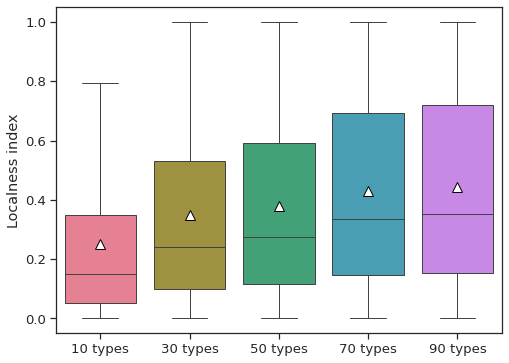

CPU times: user 17.6 s, sys: 2.77 s, total: 20.3 s
Wall time: 20.2 s


In [11]:
%%time
# Plot the boxplots
meanprops = {"marker": "^", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10}
sns.set_theme(style="ticks", rc={'figure.figsize':(8,6)},font_scale=1.2)
ax = sns.boxplot(x="Dataset", y="Value", data=df_melted,showfliers=False,palette="husl",showmeans=True,meanprops=meanprops)

plt.xlabel("")
plt.ylabel("Localness index")
ax.set_xticklabels(['10 types', '30 types','50 types','70 types','90 types'])
plt.savefig('./output/plot_localness_sensetivity.pdf', bbox_inches="tight")
plt.show()